In [108]:
!pip install tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam,SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
!pip install openpyxl

In [109]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
df = pd.read_excel("all_states_aggregate.xlsx")
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date', inplace=True)

df.replace(0, np.nan, inplace=True)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
# df = df.interpolate(method="pad")
df = df.interpolate(method="linear", limit_direction="both")

for col in df.columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.columns:
    if (df[col] < 0).any():
        smooth_mean = df.loc[df[col] > 0, col].mean()
        df[col] = df[col].apply(lambda x: x if x > 0 else smooth_mean)

scaler=RobustScaler()
scaled_values=scaler.fit_transform(df)
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)
lag = 90
X, y = create_lagged_dataset(scaled_values, lag)
split=int(len(X)*0.80)
X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_ann.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model.fit(X_train, y_train, epochs=500, batch_size=5,callbacks=[early_stop, model_checkpoint], verbose=1)

y_pred=model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
y_pred_inv=scaler.inverse_transform(y_pred)
y_test_inv=scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv,y_pred_inv)
mse = mean_squared_error(y_test_inv,y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - loss: 124.8023
Epoch 2/500


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 148.1431
Epoch 3/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 128.7090
Epoch 4/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 123.9121
Epoch 5/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 109.1057
Epoch 6/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 109.2636
Epoch 7/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 112.6607
Epoch 8/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 123.0608
Epoch 9/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 113.2593
Epoch 10/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 105.4410
Epoch 11/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 100.1577
Epoch 12/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 119.6733
Epoch 13/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 95.5355
Epoch 14/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 110.0076
Epoch 15/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 131.4613
Epoch 16/500
55/55 ━━━━━━━━━━━━━━━━━━━━ 6

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU
import pickle

In [111]:

df = pd.read_excel("all_states_aggregate.xlsx")
df.dropna(subset=['Date'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

full_dates = pd.DataFrame({'Date': pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')})
df = full_dates.merge(df, on='Date', how='left')
df.set_index('Date', inplace=True)

for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.replace(0, np.nan, inplace=True)
# df = df.interpolate(method="polynomial", order=2, limit_direction="both")
df = df.interpolate(method="linear", limit_direction="both")

for col in df.columns:
    df[col] = df[col].fillna(df[col].median())

for col in df.columns:
    if (df[col] < 0).any():
        smooth_mean = df.loc[df[col] > 0, col].mean()
        df[col] = df[col].apply(lambda x: x if x > 0 else smooth_mean)

scaler=RobustScaler()
scaled_values=scaler.fit_transform(df)
def create_lagged_dataset(data, lag):
    X, y = [], []
    for i in range(lag, len(data)):
        X.append(data[i - lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)
lag = 90
X, y = create_lagged_dataset(scaled_values, lag)
split=int(len(X))
X_train,X_test=X[:split],X[:split]
y_train,y_test=y[:split],y[:split]

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model_ann.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
model.fit(X_train, y_train, epochs=550, batch_size=5,callbacks=[early_stop, model_checkpoint], verbose=1)

y_pred=model.predict(X_test)
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
y_pred_inv=scaler.inverse_transform(y_pred)
y_test_inv=scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv,y_pred_inv)
mse = mean_squared_error(y_test_inv,y_pred_inv)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
with open('model_ann.pkl','wb') as file:
  pickle.dump(model,file)


Epoch 1/550


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - loss: 558.7196
Epoch 2/550


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 527.1609
Epoch 3/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 511.0290
Epoch 4/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 428.6938
Epoch 5/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 493.0984
Epoch 6/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 432.0357
Epoch 7/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 433.9789
Epoch 8/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 439.1845
Epoch 9/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 484.2191
Epoch 10/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 480.4339
Epoch 11/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 487.3144
Epoch 12/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 375.3424
Epoch 13/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 461.0699
Epoch 14/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 455.0359
Epoch 15/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 381.9651
Epoch 16/550
69/69 ━━━━━━━━━━━━━━━━━━━━ 

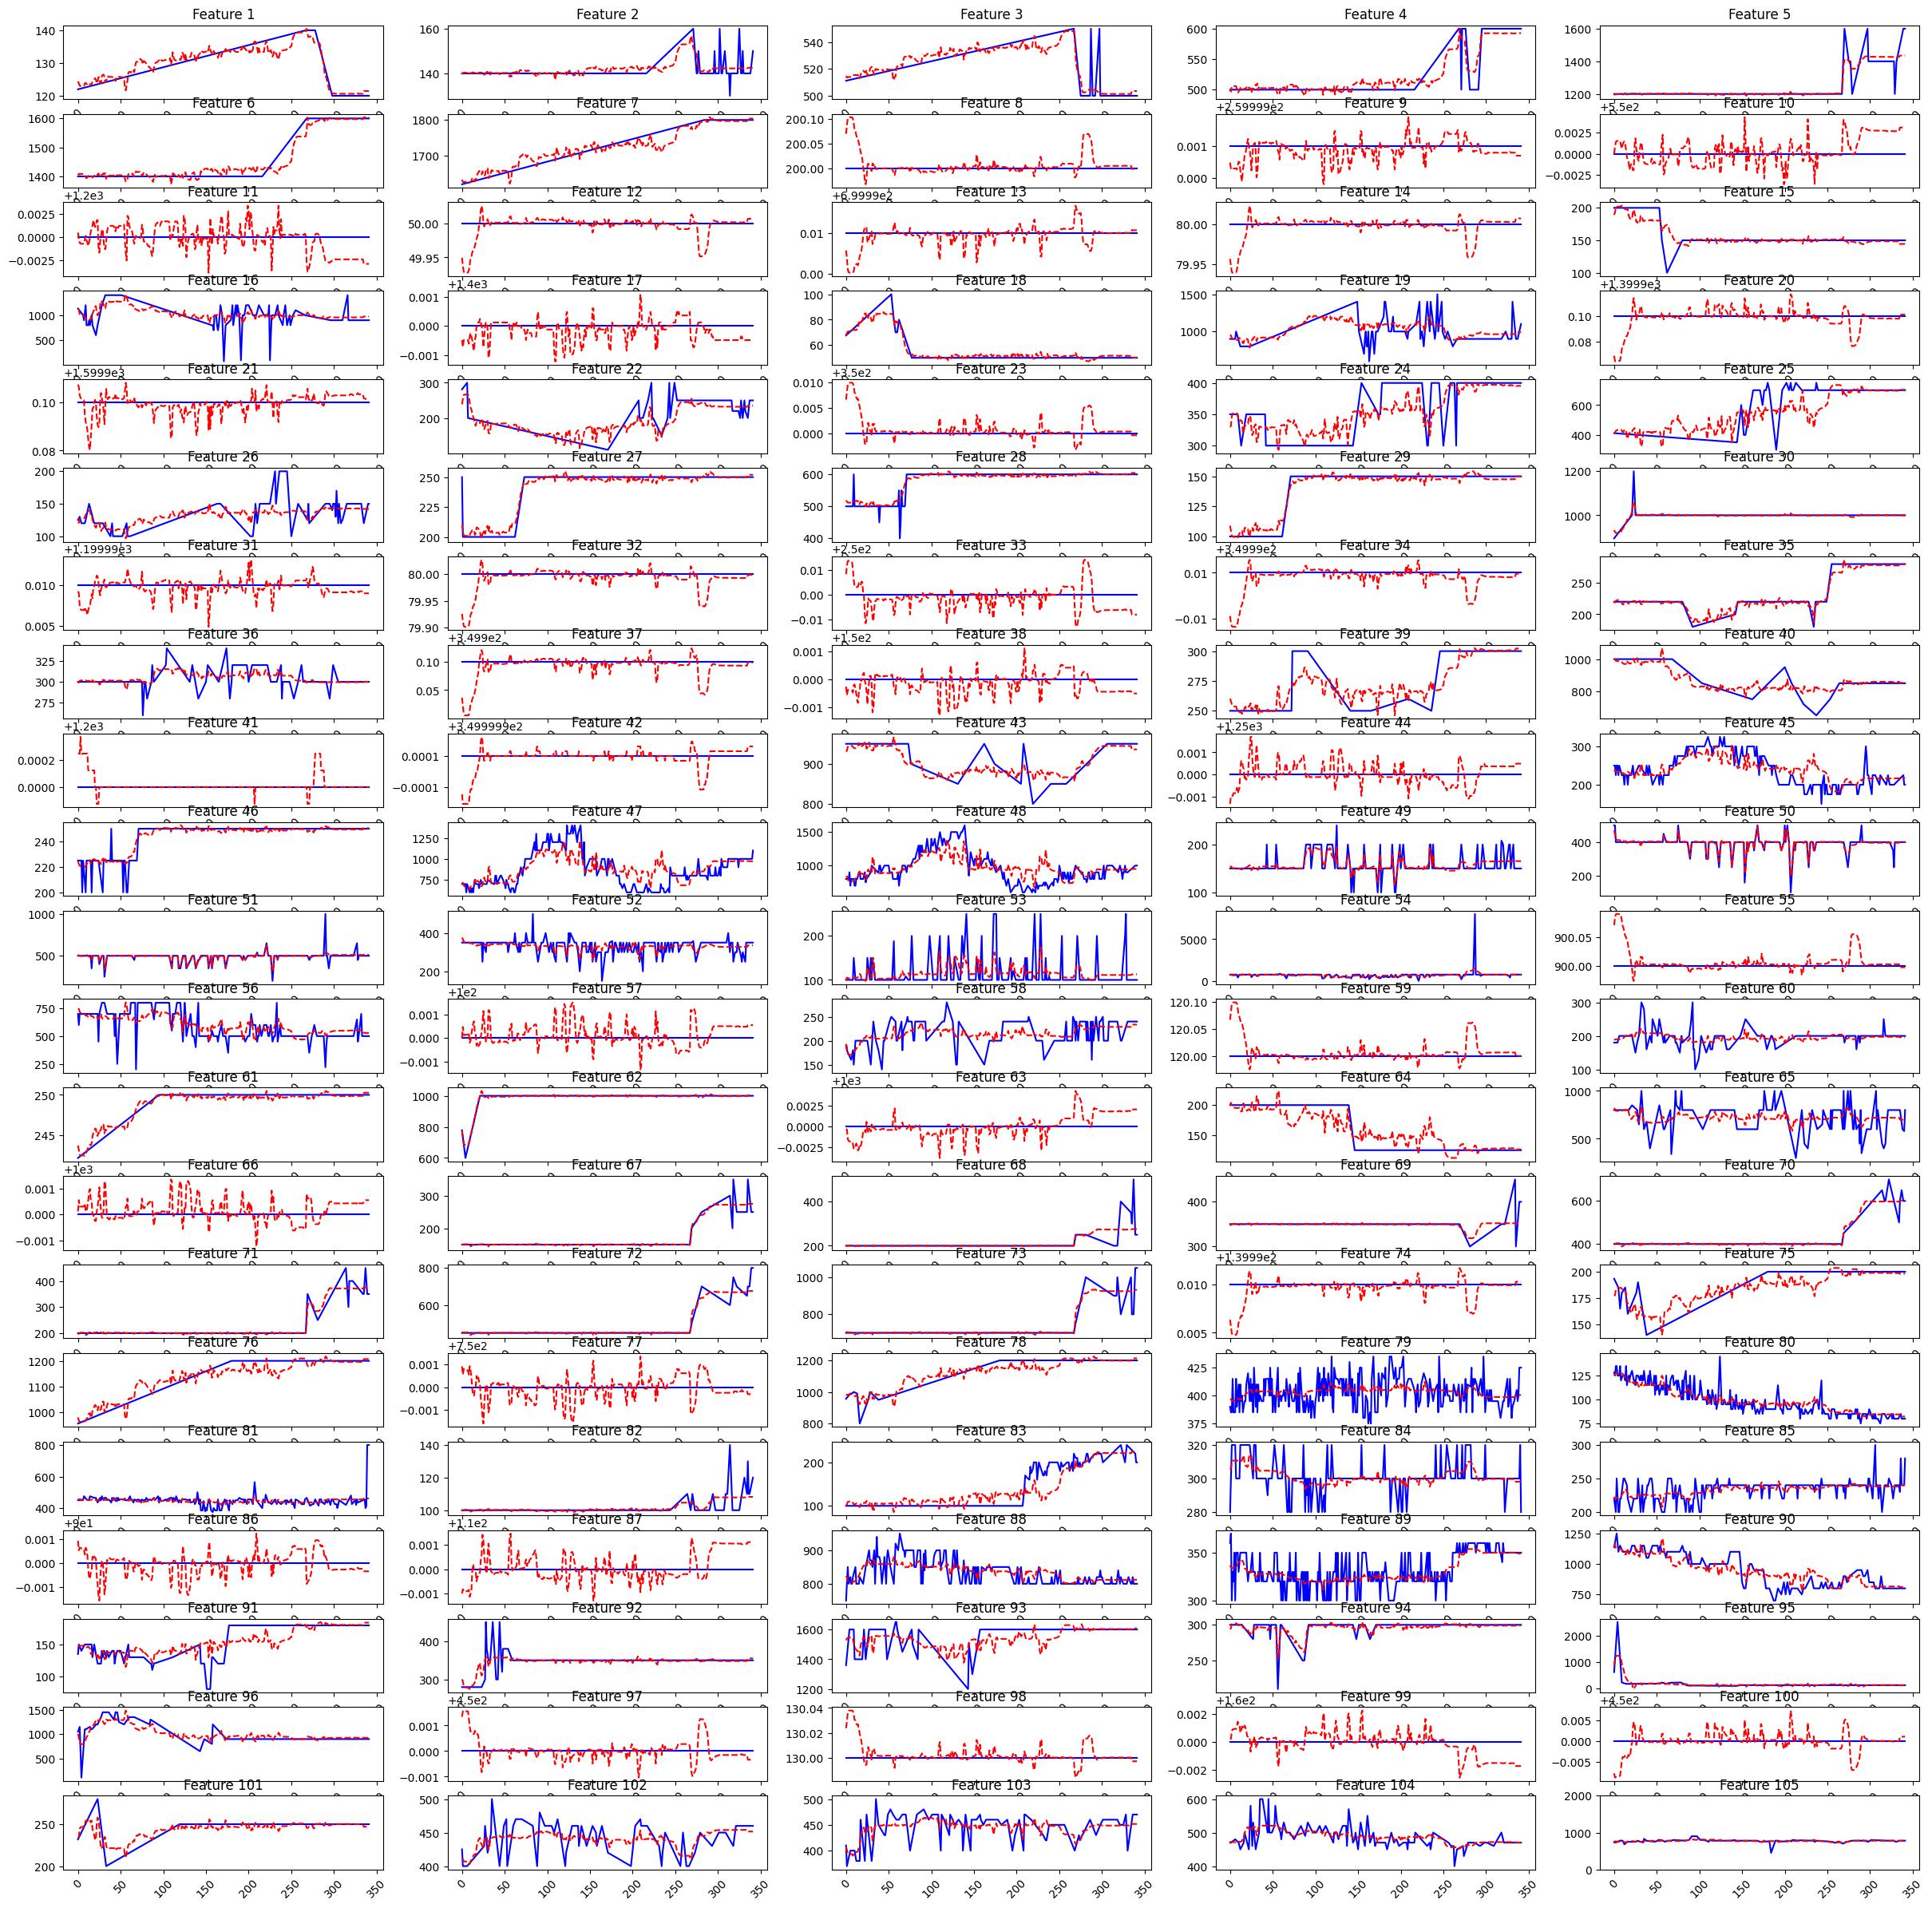

In [112]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=21, ncols=5, figsize=(30,30))
axes = axes.flatten()


for i in range(y_test_inv.shape[1]):
    axes[i].plot(y_test_inv[:, i], label=f"Actual Feature {i + 1}", color="blue")
    axes[i].plot(y_pred_inv[:, i], label=f"Predicted Feature {i + 1}", linestyle="--", color="red")

    axes[i].set_title(f"Feature {i + 1}")
    axes[i].tick_params(axis='x', rotation=45)

plt.ylim(0,2000)
plt.show()

